In [1]:
from dataclasses import dataclass, field
from typing import List

@dataclass
class State:
    job_description: str = ""
    resume: str = ""
    summary: str = ""
    skills: List[str] = field(default_factory=list)
    match_score: float = 0.0
    suggestions: str = ""


In [2]:
import warnings
import os
from dotenv import load_dotenv
warnings.filterwarnings('ignore')
load_dotenv(override=True)
# print(os.getenv("GROQ_API_KEY"))

True

#### Creating each nodes
1. Summarize the JD

In [3]:
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage
from dataclasses import replace
from langchain_core.prompts import ChatPromptTemplate

llm= ChatGroq(model="gemma2-9b-it", temperature= 0)

def Summarize_node(state:State):
    jd = state.job_description
    response =llm.invoke([
        HumanMessage(content=f"Summarize the following job description in 3 lines: \n{jd} ")
    ])

    summary =response.content
    return replace(state, summary=summary)

2. Extract Skills

In [4]:
def extract_skills_node(state:State):
    jd = state.job_description
    
    prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are an expert recruiter extracting key skills."),
    ("human", "Extract only the key technical and soft skills from the following job description and return them as a flat Python list (no explanations or formatting):\n\n{jd}")
])

    prompt = prompt_template.format_messages(jd=jd)

    response = llm.invoke(prompt)

    skills_text = response.content

    try:
        skills = eval(skills_text)
        if not isinstance(skills, list):
            raise ValueError()
    
    except:
        skills = [s.strip() for s in skills_text.split(",")]

    return replace(state, skills=skills)


3. Match_Resume node

In [5]:
def match_resume_node(state: State):
    skills = state.skills
    resume = state.resume.lower()

    matched = [skill for skill in skills if skill.lower() in resume]
    score =round ((len(matched) / len(skills))*100, 2) if skills else 0.0

    return replace(state, match_score=score)

4. Suggest Improvements

In [6]:
def suggest_improvements_node(state:State):
    llm = ChatGroq(model="gemma2-9b-it", temperature= 0.3)
    jd = state.job_description
    resume = state.resume

    prompt =(
        f"My resume is : \n{resume}\n\n"
        f"Job Description: \n{jd}\n\n"
        f"Suggest specific improvements to better match the resume to this JD."
    )
    
    response = llm.invoke(prompt)
    return replace(state, suggestions=response.content)



In [7]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)

builder.add_node("Summarize", Summarize_node)
builder.add_node("extract_skills",extract_skills_node)
builder.add_node("match_resume", match_resume_node)
builder.add_node("Suggestions", suggest_improvements_node)

builder.add_edge(START, "Summarize")
builder.add_edge("Summarize", "extract_skills")
builder.add_edge("extract_skills", "match_resume")

#Conditional edge
def check_match(state):
    return "Suggestions" if state.match_score < 75 else "end"

builder.add_conditional_edges(
    "match_resume",
    check_match,
    {
        "Suggestions": "Suggestions",
        "end": END
    }
)


builder.add_edge("Suggestions", END)


app= builder.compile()


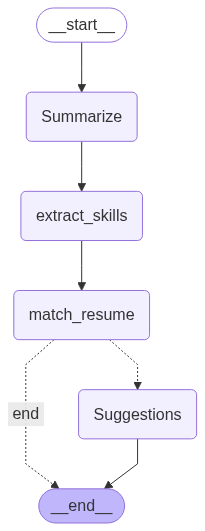

In [8]:
app

In [9]:
jd_text = """
    We are looking for a Data Scientist with strong expertise in Machine Learning, Natural Language Processing (NLP), Python, and SQL.
    Experience with cloud platforms and deploying models into production is a plus.
    """

resume_text = """
    I am a data enthusiast with experience in Python, data cleaning, and SQL.
    I have done academic projects on regression analysis and data visualization.
    """

result = app.invoke({
        "job_description": jd_text,
        "resume": resume_text
    })

print("\n--- RESULT ---")
print("✅ JD Summary:\n", result["summary"])
print("\n🔑 Extracted Skills:\n", result["skills"])
print("\n📊 Match Score:\n", result["match_score"])

if result["match_score"] < 75:
    print("\n🔁 Suggestions to Improve Resume:\n", result["suggestions"])


--- RESULT ---
✅ JD Summary:
 This role seeks a Data Scientist proficient in Machine Learning, NLP, Python, and SQL.  
Experience with cloud platforms and production model deployment is highly valued.  
The ideal candidate will leverage these skills to drive data-driven insights and solutions. 




🔑 Extracted Skills:
 ['Machine Learning', 'Natural Language Processing (NLP)', 'Python', 'SQL', 'cloud platforms', 'deploying models']

📊 Match Score:
 33.33

🔁 Suggestions to Improve Resume:
 Here's a breakdown of how to improve your resume to better align with the job description, along with specific suggestions:

**Understanding the Gaps**

The job description emphasizes:

* **Machine Learning (ML) and Natural Language Processing (NLP):**  These are core skills missing from your current resume.
* **Production Deployment:**  Experience getting models into real-world use is a significant plus.
* **Cloud Platforms:** Familiarity with platforms like AWS, Azure, or GCP is desirable.

**Resume